In [1]:
# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas display options efficiently
pd.set_option('display.max_rows', None)  # Avoid setting to None (can slow down rendering)
pd.set_option('display.max_columns', None)  # Limit to a reasonable number

# Suppress specific warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)


In [3]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.2.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-27 14:56:18.598052: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-02-27 14:56:18.634608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-27 14:56:18.634849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2025-02-27 14:56:18.635235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-02-27 14:56:18.637741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-27 14:56:18.639691: I tensorflow/stream_executor/platform

#### Data Loading

In [4]:
# Load the data
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [5]:
# concatenate all dataframes
df = pd.concat([df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [6]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,1,53,1,2021,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,1,53,1,2021,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,1,53,1,2021,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,1,53,1,2021,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


#### Data Pre-processing

In [7]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# sort values by datetime_
df.sort_values('datetime_', inplace=True, ascending=True)

# remove lag terms
df.drop(columns = [col for col in df.columns if col.startswith('alberta_internal_load_lag')], inplace = True)
df.drop(columns = [col for col in df.columns if col.startswith('pool_price_lag')], inplace = True)

In [8]:
df.shape

(35076, 21)

In [9]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,1,53,1,2021,1
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,1,53,1,2021,1
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,1,53,1,2021,1
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,1,53,1,2021,1
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,1,53,1,2021,1


In [10]:
# check for missing observations
(df["datetime_"].diff().dt.total_seconds() // 3600).value_counts()

1.0    35063
0.0       12
Name: datetime_, dtype: int64

In [11]:
target_column = "pool_price"

# Exclude datetime column
df = df.drop(columns=["datetime_"])

# Separate features and target
X = df.values #df.drop(columns=[target_column]).values
y = df[target_column].values

# Normalize features using StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + 1 : i + 1 + time_steps])
    return np.array(Xs), np.array(ys)

# Define sequence length (24 hours)
time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print(X_seq.shape, y_seq.shape)

(35052, 24, 20) (35052, 24, 1)


#### Train-Test split

In [12]:
# Split into training and testing sets
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# shape of training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(28041, 24, 20) (7011, 24, 20)
(28041, 24, 1) (7011, 24, 1)


#### LSTM modeling

In [13]:
# Build LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Explicit Input layer
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(24)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

2025-02-27 14:56:20.459538: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-02-27 14:56:20.504558: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2025-02-27 14:56:20.505387: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7d9c000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-27 14:56:20.505457: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-27 14:56:20.613853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-27 14:56:20.614195: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3fb1cba0 initialized for platform CUDA (this does not guarantee that XLA wil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            21760     
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
Total params: 35,112
Trainable params: 35,112
Non-trainable params: 0
____________________________________________________

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


2025-02-27 14:56:27.877454: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-27 14:56:28.149250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


701/701 [==============================] - 8s 11ms/step - loss: 0.5259 - mae: 0.4199 - val_loss: 0.2623 - val_mae: 0.3215
Epoch 2/20
701/701 [==============================] - 6s 9ms/step - loss: 0.3286 - mae: 0.3256 - val_loss: 0.2072 - val_mae: 0.2787
Epoch 3/20
701/701 [==============================] - 8s 12ms/step - loss: 0.2807 - mae: 0.2973 - val_loss: 0.1664 - val_mae: 0.2420
Epoch 4/20
701/701 [==============================] - 7s 11ms/step - loss: 0.2595 - mae: 0.2836 - val_loss: 0.1502 - val_mae: 0.2240
Epoch 5/20
701/701 [==============================] - 7s 10ms/step - loss: 0.2439 - mae: 0.2744 - val_loss: 0.1388 - val_mae: 0.2163
Epoch 6/20
701/701 [==============================] - 7s 10ms/step - loss: 0.2341 - mae: 0.2689 - val_loss: 0.1351 - val_mae: 0.2150
Epoch 7/20
701/701 [==============================] - 7s 10ms/step - loss: 0.2256 - mae: 0.2642 - val_loss: 0.1272 - val_mae: 0.2067
Epoch 8/20
701/701 [==============================] - 7s 9ms/step - loss: 0.2176 

#### Model Performance Check

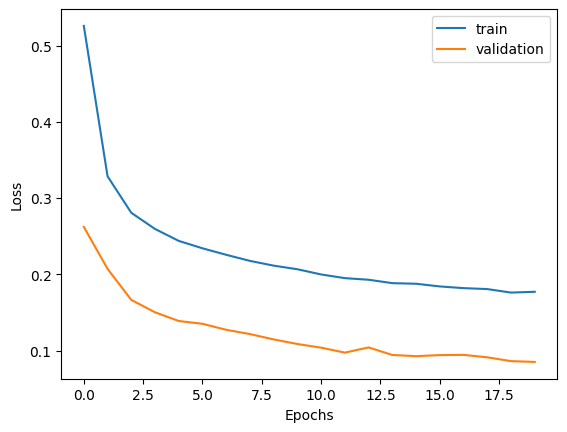

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Predict on test data
y_test_pred = model.predict(X_test)

# Reverse scaling
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))

# Compute performance metrics
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
r2 = r2_score(y_test_inv, y_test_pred_inv)

print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MAE: 27.32
Test R² Score: 0.85


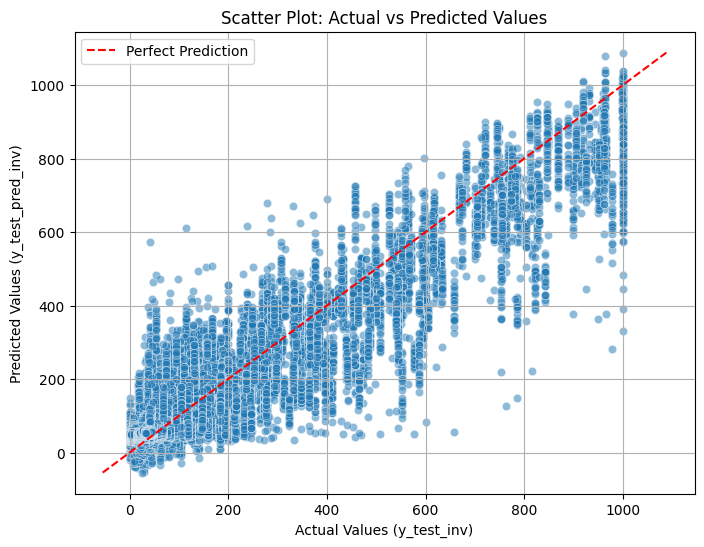

In [17]:
# Flatten the arrays to convert (7011, 24) → (7011*24,)
y_test_inv_flat = y_test_inv.flatten()
y_test_pred_inv_flat = y_test_pred_inv.flatten()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_inv_flat, y=y_test_pred_inv_flat, alpha=0.5)

# Plot a perfect prediction reference line (y = x)
min_val = min(y_test_inv_flat.min(), y_test_pred_inv_flat.min())
max_val = max(y_test_inv_flat.max(), y_test_pred_inv_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Values (y_test_inv)")
plt.ylabel("Predicted Values (y_test_pred_inv)")
plt.title("Scatter Plot: Actual vs Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Hourly Statistics

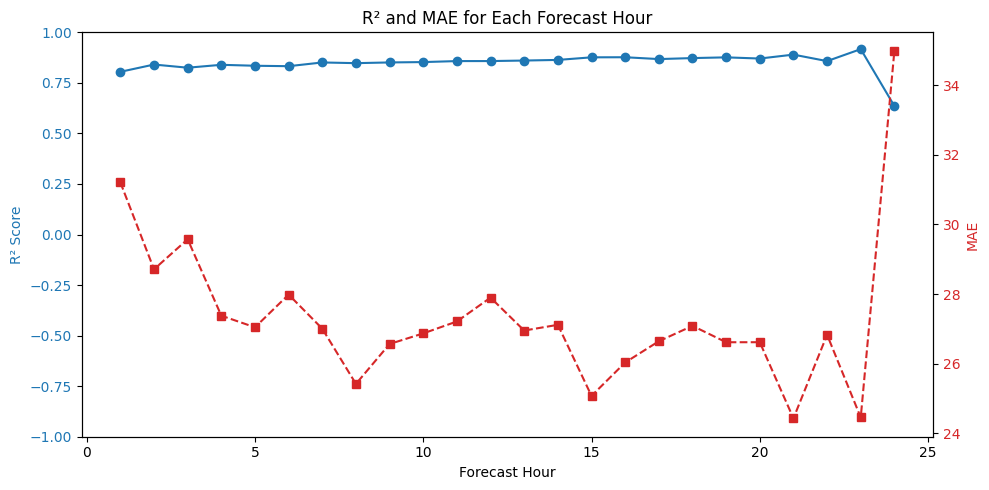

In [18]:
# Initialize lists to store R² and MAE for each hour
r2_scores = []
mae_scores = []

# Compute R² and MAE for each hour separately
for hour in range(24):
    r2 = r2_score(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    mae = mean_absolute_error(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    
    r2_scores.append(r2)
    mae_scores.append(mae)

# Convert lists to NumPy arrays
r2_scores = np.array(r2_scores)
mae_scores = np.array(mae_scores)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot R² scores
ax1.set_xlabel("Forecast Hour")
ax1.set_ylabel("R² Score", color="tab:blue")
ax1.plot(range(1, 25), r2_scores, marker="o", linestyle="-", color="tab:blue", label="R² Score")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(-1, 1)  # R² can be negative

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE", color="tab:red")
ax2.plot(range(1, 25), mae_scores, marker="s", linestyle="--", color="tab:red", label="MAE")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Add titles and legend
plt.title("R² and MAE for Each Forecast Hour")
fig.tight_layout()
plt.show()
